### Example of how the Calculation library works

In [51]:
import pandas as pd
import numpy as np
import psf_library.cleaning as psf_clean 
import psf_library.calcs as psf_calc

#### Loading in our data so that we can work with it

In [52]:
returns_df = pd.read_csv('10Y_Daily_Returns.csv')
returns_df

,date,SPX Index,SPW Index,MXEA Index,MXWOU Index
0,2015-06-01,0.002160,0.001531,-0.004005,-0.003767
1,2015-06-02,-0.000956,0.000282,0.006633,0.006924
2,2015-06-03,0.002306,0.001293,0.007195,0.006880
3,2015-06-04,-0.008607,-0.008954,-0.006884,-0.007195
4,2015-06-05,-0.001395,0.000279,-0.019839,-0.018510
...,...,...,...,...,...
2605,2025-05-26,0.000000,0.000000,0.010635,0.010455
2606,2025-05-27,0.020543,0.018210,-0.001083,-0.000320
2607,2025-05-28,-0.005560,-0.008963,-0.007636,-0.007189
2608,2025-05-29,0.004027,0.003032,0.006744,0.005677


#### Calculating different rolling returns would take about 35 lines of code

In [53]:
returns_df['date'] = pd.to_datetime(returns_df['date'])

num_returns = 252
time_period = 3
rolling_count = time_period * num_returns

metrics_dict = {}

index_cols = ['SPX Index', 'SPW Index', 'MXEA Index', 'MXWOU Index']
metrics_to_plot = ['cumulative_return', 'rolling_cumulative_return', 'annualized_return', 'rolling_volatility', 'rolling_sharpe']

for idx in index_cols:
    df = returns_df[['date', idx]].copy()
    df.set_index('date', inplace=True)
    returns = df[idx]

    cumulative_return = (1 + returns).cumprod() - 1
    rolling_cumulative_return = (1 + returns).rolling(rolling_count).apply(np.prod, raw=True) - 1
    
    rolling_total = (1 + returns).rolling(rolling_count).apply(np.prod, raw=True) - 1
    rolling_annualized = (1 + rolling_total) ** (num_returns / rolling_count) - 1
    
    rolling_volatility = returns.rolling(rolling_count).std() * np.sqrt(num_returns)
    rolling_sharpe = (rolling_annualized - 0.03) / rolling_volatility

    metrics_df = pd.DataFrame({
        'cumulative_return': cumulative_return,
        'rolling_cumulative_return': rolling_cumulative_return,
        'annualized_return': rolling_annualized,
        'rolling_volatility': rolling_volatility,
        'rolling_sharpe': rolling_sharpe
    }, index=df.index)

    metrics_dict[idx] = metrics_df.reset_index()

metrics_dict['SPX Index'].tail(1)

,date,cumulative_return,rolling_cumulative_return,annualized_return,rolling_volatility,rolling_sharpe
2609,2025-05-30,2.348587,0.582009,0.165207,0.171106,0.790192


#### Calculating different rolling returns with the library takes about 10 lines of code
This means that you are saving 25 lines of code by using the library

In [55]:
split = psf_clean.split_columns_to_dfs(returns_df, 'date')
index_cols = ['SPX Index', 'SPW Index', 'MXEA Index', 'MXWOU Index']
saved = {}

for idx in index_cols:
    df = psf_calc.compute_rolling_returns(split[idx], 3, 0.03)
    saved[idx] = df

saved['SPX Index'].tail(1)

,date,cumulative_return,rolling_cumulative_return,annualized_return,rolling_volatility,rolling_sharpe
2609,2025-05-30,2.348587,0.582009,0.165207,0.171106,0.790192


### Example of how the Plotting library works

#### To build a graph comparing cumulative returns of the indexes it takes about 30 lines of code

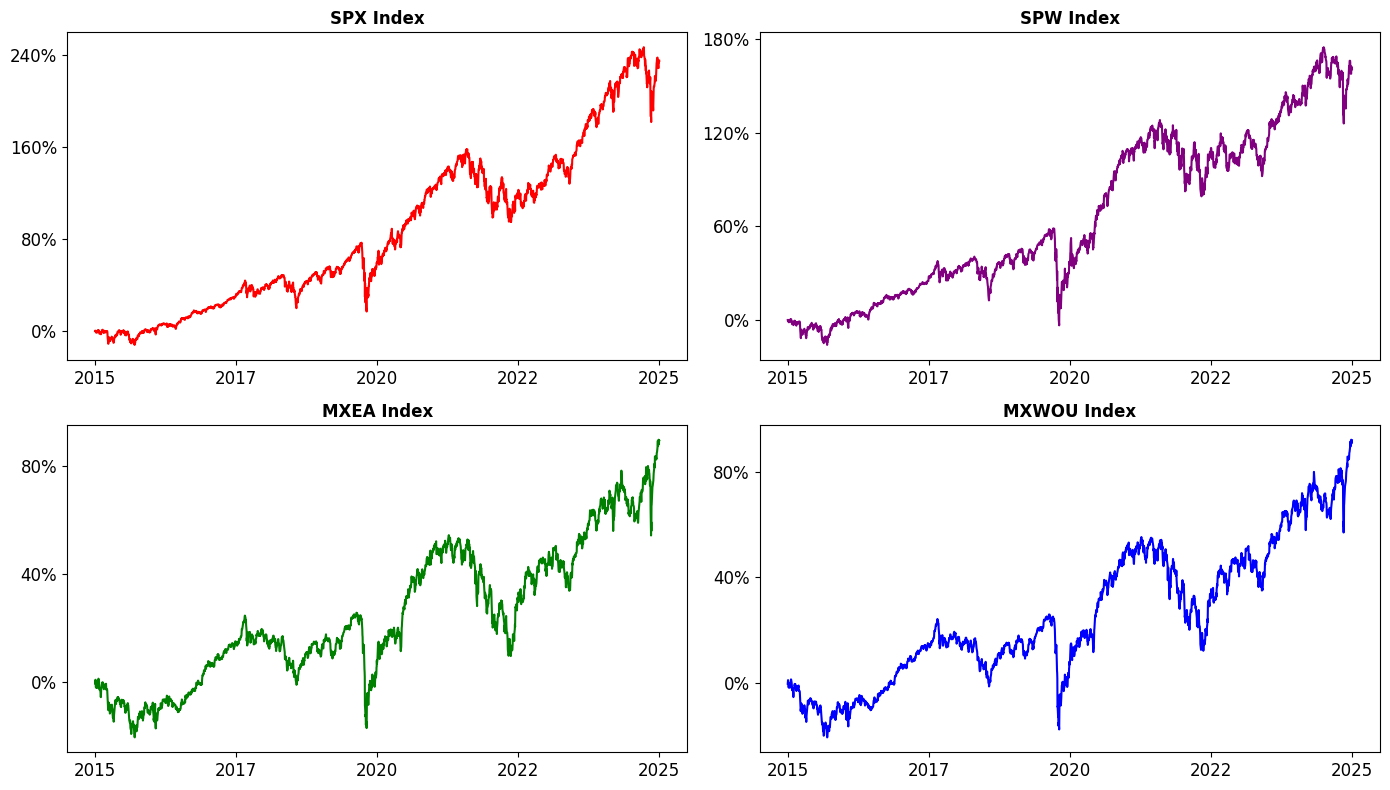

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import PercentFormatter
import matplotlib.dates as mdates

index_cols = ['SPX Index', 'SPW Index', 'MXEA Index', 'MXWOU Index']
colors = ['red', 'purple', 'green', 'blue']

fig, axs = plt.subplots(2, 2, figsize=(14, 8))
axs = axs.flatten()

for i, idx in enumerate(index_cols):
    df = metrics_dict[idx]
    axs[i].plot(df['date'], df['cumulative_return'], color=colors[i])
    axs[i].set_title(f"{idx}", fontweight='bold')
    axs[i].tick_params(labelsize=12)
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')
    axs[i].yaxis.set_major_locator(MaxNLocator(nbins=4))
    axs[i].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))

    start_date = df['date'].iloc[0]
    end_date = df['date'].iloc[-1]
    tick_dates = pd.date_range(start=start_date, end=end_date, periods=5)
    axs[i].set_xticks(tick_dates)
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.tight_layout()
plt.show()

#### To build a graph comparing cumulative returns of the indexes it takes about 10 lines of code with the library
This means that with the library you are saving about 20 lines of code

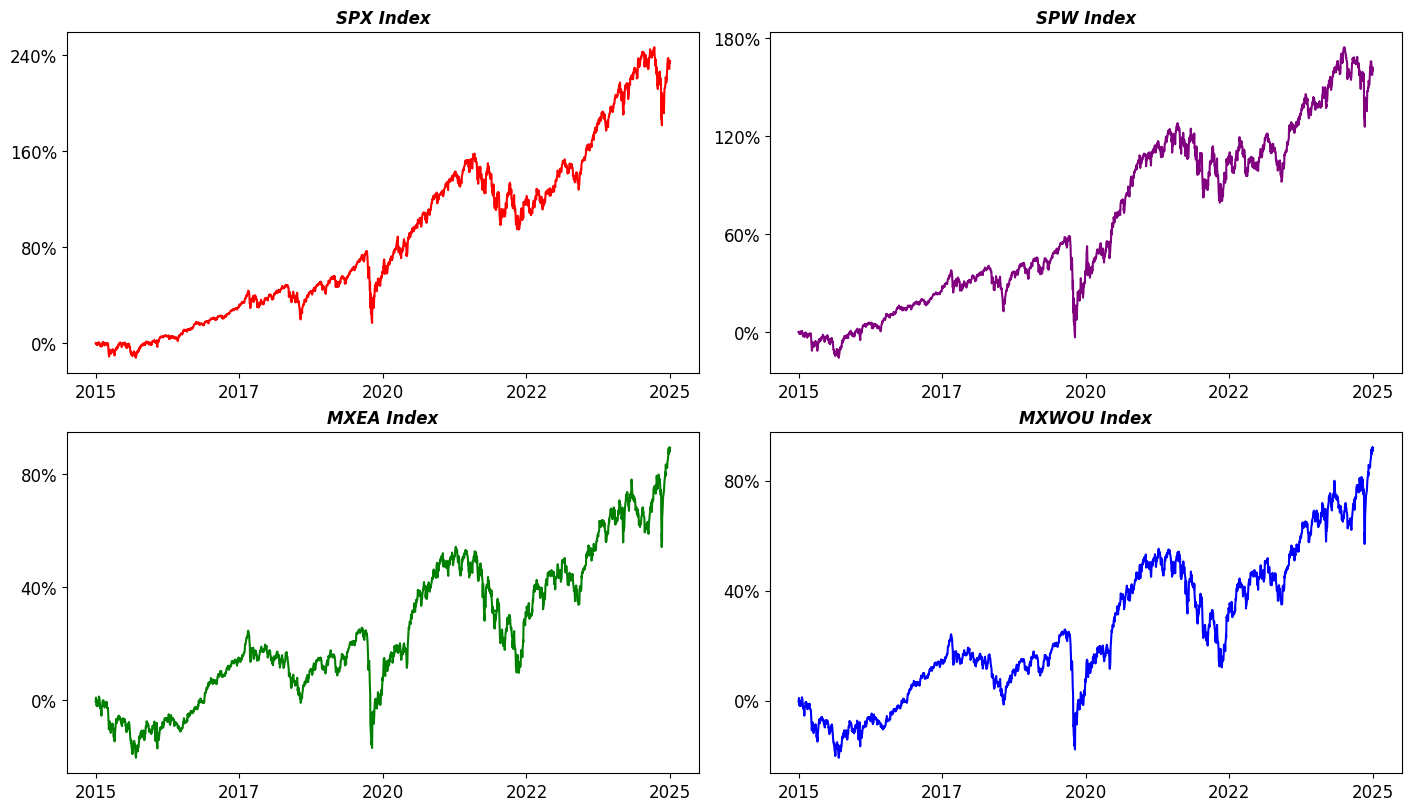

In [60]:
import pandas as pd
import psf_library.cleaning as psf_clean
import psf_library.plotting as psf_plot

index_list = ['SPX Index', 'SPW Index', 'MXEA Index', 'MXWOU Index']
colors = ['red', 'purple', 'green', 'blue']

fig, axes, dfs = psf_plot.plot_colored_lines(index_list, colors, saved, 'cumulative_return', 'date', 2, 2, (14,8), 'o')

for ax, df, index in zip(axes, dfs, index_list):
    psf_plot.style_axes_date(ax, df, index, 'increase_percent', 5, '%Y')